In [1]:
import pandas as pd
import polars as pl
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib
import npc_lims
# from npc_sessions import DynamicRoutingSession
from dynamic_routing_analysis import spike_utils
from dynamic_routing_analysis import data_utils

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import os
import pickle
import upath

%load_ext autoreload
%autoreload 2
# %matplotlib widget

In [2]:
# get list of sessions to run on
session_table_path=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\session_table_v0.272.csv"
session_table=pl.read_csv(session_table_path)

dr_session_list=(
    session_table.filter(
    pl.col('project')=="DynamicRouting",
    pl.col('is_production'),
    pl.col('is_annotated'),
    pl.col('issues')=="",
    pl.col('is_good_behavior').eq(True),
    pl.col('is_engaged').eq(True),
    )['session_id'].to_list()
    )

In [3]:
# loadpath=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\PCA task vs spont projection\post_task\all_sessions_structure_pca_projections.parquet"
# loadpath=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\PCA task vs spont projection\pre_task\all_sessions_structure_pca_projections.parquet"
loadpath=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\PCA task vs spont projection\pre_task_spont_only\all_sessions_structure_pca_projections.parquet"

results_df=pd.read_parquet(loadpath)

Text(0.5, 0.98, 'ACAd; 664851_2023-11-13: ')

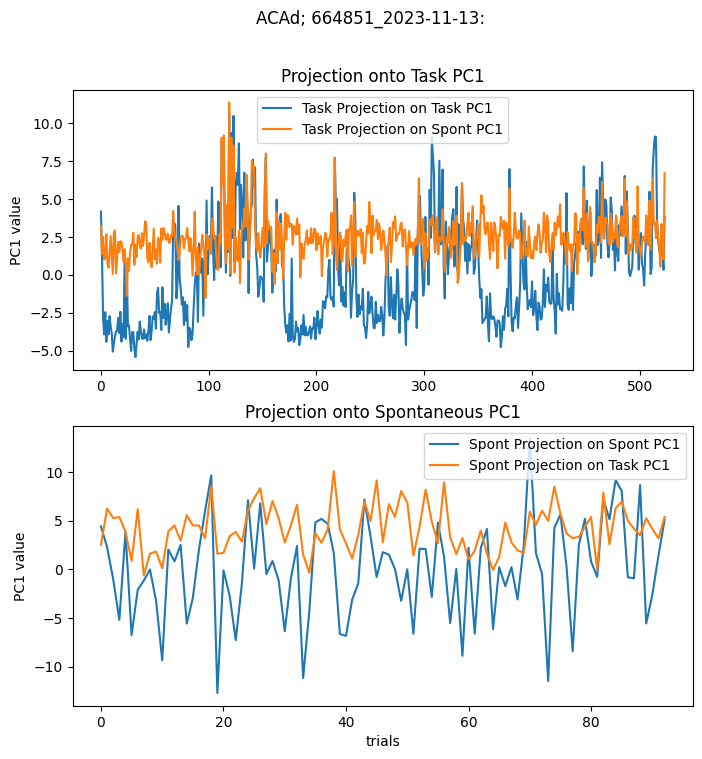

In [16]:
#plot examples

sel_session='664851_2023-11-13'
# sel_session='742903_2024-10-22'
# sel_session='670180_2023-07-27'

sel_structure='ACAd'

session_structure_df=results_df.query(f'session_id=="{sel_session}" and structure=="{sel_structure}"')
# session_structure_df

fig,ax=plt.subplots(2,1,figsize=(8,8))

ax[0].plot(session_structure_df['task_projection_on_task_PC1'].values[0], label='Task Projection on Task PC1')
ax[0].plot(session_structure_df['task_projection_on_spont_PC1'].values[0], label='Task Projection on Spont PC1')

ax[0].set_title('Projection onto Task PC1')
ax[0].legend()

ax[1].plot(session_structure_df['spont_projection_on_spont_PC1'].values[0], label='Spont Projection on Spont PC1')
ax[1].plot(session_structure_df['spont_projection_on_task_PC1'].values[0], label='Spont Projection on Task PC1')
ax[1].set_title('Projection onto Spontaneous PC1')
ax[1].legend()

ax[1].set_xlabel('trials')
ax[0].set_ylabel('PC1 value')
ax[1].set_ylabel('PC1 value')

fig.suptitle(f'{sel_structure}; {sel_session}: ')

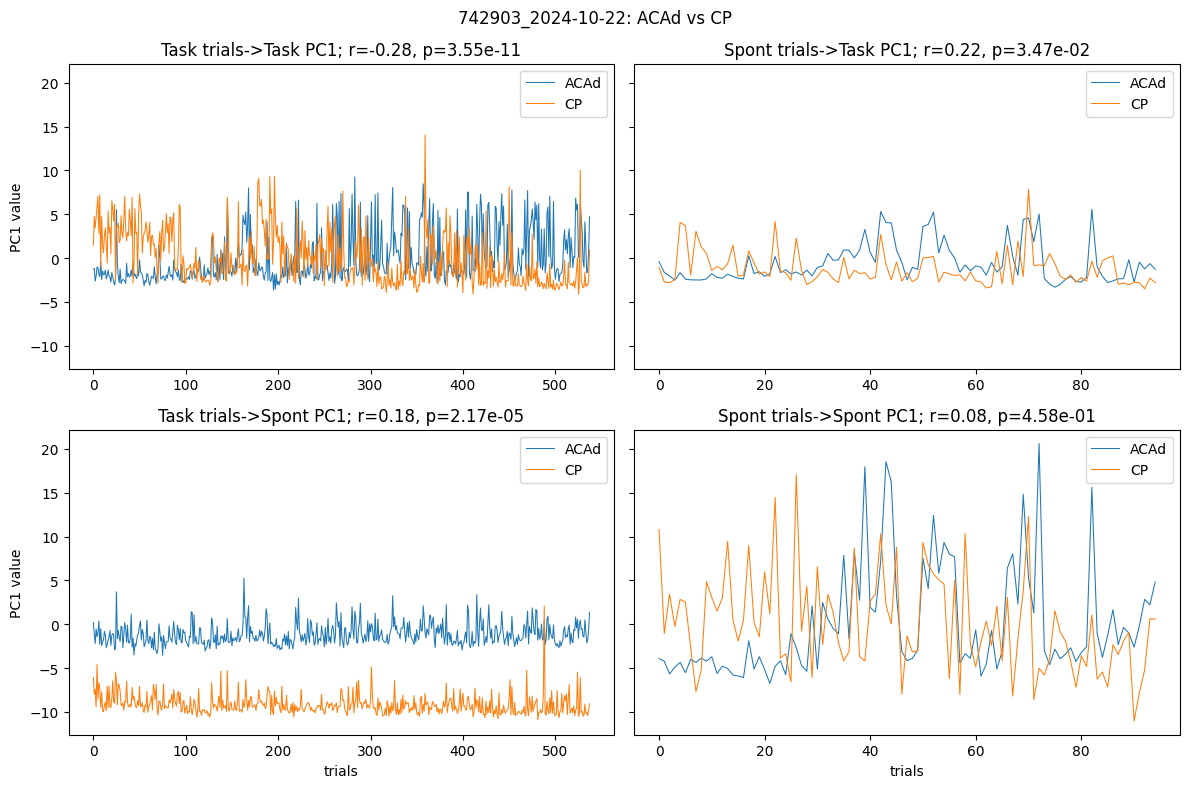

In [29]:
#plot example correlations across areas
# sel_session='664851_2023-11-13'
sel_session='742903_2024-10-22'
sel_structure1='ACAd'
sel_structure2='CP'

session_structure_df1=results_df.query(f'session_id=="{sel_session}" and structure=="{sel_structure1}"')
session_structure_df2=results_df.query(f'session_id=="{sel_session}" and structure=="{sel_structure2}"')

fig,ax=plt.subplots(2,2,figsize=(12,8),sharey=True)


ax[0,0].plot(session_structure_df1['task_projection_on_task_PC1'].values[0], label=f'{sel_structure1}',linewidth=0.75)
ax[0,0].plot(session_structure_df2['task_projection_on_task_PC1'].values[0], label=f'{sel_structure2}',linewidth=0.75)
r,p=stats.pearsonr(session_structure_df1['task_projection_on_task_PC1'].values[0], session_structure_df2['task_projection_on_task_PC1'].values[0])
ax[0,0].set_title(f'Task trials->Task PC1; r={r:.2f}, p={p:.2e}')
ax[0,0].set_ylabel('PC1 value')
ax[0,0].legend()

ax[1,0].plot(session_structure_df1['task_projection_on_spont_PC1'].values[0], label=f'{sel_structure1}',linewidth=0.75)
ax[1,0].plot(session_structure_df2['task_projection_on_spont_PC1'].values[0], label=f'{sel_structure2}',linewidth=0.75)
r,p=stats.pearsonr(session_structure_df1['task_projection_on_spont_PC1'].values[0], session_structure_df2['task_projection_on_spont_PC1'].values[0])
ax[1,0].set_title(f'Task trials->Spont PC1; r={r:.2f}, p={p:.2e}')
ax[1,0].set_ylabel('PC1 value')
ax[1,0].set_xlabel('trials')
ax[1,0].legend()

ax[0,1].plot(session_structure_df1['spont_projection_on_task_PC1'].values[0], label=f'{sel_structure1}',linewidth=0.75)
ax[0,1].plot(session_structure_df2['spont_projection_on_task_PC1'].values[0], label=f'{sel_structure2}',linewidth=0.75)
r,p=stats.pearsonr(session_structure_df1['spont_projection_on_task_PC1'].values[0], session_structure_df2['spont_projection_on_task_PC1'].values[0])
ax[0,1].set_title(f'Spont trials->Task PC1; r={r:.2f}, p={p:.2e}')
ax[0,1].legend()

ax[1,1].plot(session_structure_df1['spont_projection_on_spont_PC1'].values[0], label=f'{sel_structure1}',linewidth=0.75)
ax[1,1].plot(session_structure_df2['spont_projection_on_spont_PC1'].values[0], label=f'{sel_structure2}',linewidth=0.75)
r,p=stats.pearsonr(session_structure_df1['spont_projection_on_spont_PC1'].values[0], session_structure_df2['spont_projection_on_spont_PC1'].values[0])
ax[1,1].set_title(f'Spont trials->Spont PC1; r={r:.2f}, p={p:.2e}')
ax[1,1].set_xlabel('trials')
ax[1,1].legend()

fig.suptitle(f'{sel_session}: {sel_structure1} vs {sel_structure2}')
fig.tight_layout()

In [96]:
# average some areas together per session:

#### hacky way to do it, would be better done above before the projection! #### - fix later

simplfied_structure_grouping = {
    'VIS': ['VISp', 'VISa', 'VISal', 'VISam', 'VISl', 'VISli', 'VISp', 'VISpl', 'VISpm', 'VISpor'],
    'AUD': ['AUDp', 'AUDv', 'AUDd', 'AUDpo'],
    'AI': ['AIp', 'AIv', 'AId'],
    'HPF': ['CA1', 'CA2', 'CA3', 'DG', 'ENTl', 'ENTm', 'PAR', 'POST', 'PRE', 'SUB', 'ProS'],
    'OLF': ['OLF','AON','AOB','MOB','TT','DP','PIR'],
    'THALsm': ['VAL','VM','VPL','VPLpc','VPM','MGd','MGv','MGm','LGd'],
    'THALpm': ['LP','PO','POL','SGN','Eth', #
               'AV','AMd','AMv','AD','IAM','IAD','LD', #
               'IMD','MD','SMT','PR', #
               'PVT','PT','RE','Xi', #
               'RH','PCN','CM','CL','PF','PIL', #
               'RT', #
               'IGL','IntG','LGv','SubG', #
               'MH','LH' #
               ],
    'AMY': ['BLAp','CEAm'],
    'BG': ['GP','GPe','GPi','SNr','SNc','VTA'],
    'LS': ['LSc','LSr','LSv'],
    # 'SCs': ['SCsg','SCzo','SCop'],
    # 'SCm': ['SCiw','SCig','SCdw','SCdg'],
}


In [97]:
results_df.columns

Index(['structure', 'task_projection_on_task_PC1',
       'spont_projection_on_task_PC1', 'task_projection_on_task_PC1_corrected',
       'task_projection_on_spont_PC1', 'spont_projection_on_spont_PC1',
       'task_projection_on_spont_PC1_corrected', 'session_id'],
      dtype='object')

In [98]:
#combine some structures?

# for each session, get the average predict proba for each structure in the simplified_structure_grouping, and delete the original structure-session row

results_df=results_df[~results_df['structure'].str.contains('SCzo|SCop|SCsg|SCiw|SCig|SCdw|SCdg|ECT1|ECT2/3|ECT4|ECT5|ECT6a|ECT6b')]

new_results_df = []

#loop through each session
for sel_session in dr_session_list:
    print(f'Processing session {sel_session}')
    
    #get the table for the session
    session_results=results_df.query(f'session_id=="{sel_session}"').reset_index(drop=True)

    #check if session has all columns

    #loop through each structure in the simplified_structure_grouping
    for new_structure, old_structures in simplfied_structure_grouping.items():
        if len(old_structures) > 1:
            #get the rows for the old structures
            old_structure_rows = session_results.query(f'structure in {old_structures}')

            #check if length of predict_proba for each rows match
            if old_structure_rows['task_projection_on_task_PC1'].apply(len).nunique() > 1:
                print(f'Warning: predict_proba lengths do not match for session {sel_session} and structures {old_structures}. Skipping...')
                continue

            if not old_structure_rows.empty:
                new_structure_row = {
                    'session_id': sel_session,
                    'structure': new_structure,
                    'task_projection_on_task_PC1': [old_structure_rows['task_projection_on_task_PC1'].mean(axis=0)],
                    'spont_projection_on_task_PC1': [old_structure_rows['spont_projection_on_task_PC1'].mean(axis=0)],
                    'task_projection_on_spont_PC1': [old_structure_rows['task_projection_on_spont_PC1'].mean(axis=0)],
                    'spont_projection_on_spont_PC1': [old_structure_rows['spont_projection_on_spont_PC1'].mean(axis=0)],
                    'task_projection_on_task_PC1_corrected': [old_structure_rows['task_projection_on_task_PC1_corrected'].mean(axis=0)],
                    'task_projection_on_spont_PC1_corrected': [old_structure_rows['task_projection_on_spont_PC1_corrected'].mean(axis=0)],
                }

                session_results = pd.concat([session_results, pd.DataFrame(new_structure_row)], axis=0, ignore_index=True)
                
                #drop the old structure rows from the new_predict_proba_pd
                session_results = session_results.query(f'structure not in {old_structures}')


        else:
            #if only one old structure, just rename it to the new structure
            session_results.loc[session_results['session_id'] == sel_session, 'structure'] = old_structures[0]

    #update the new_predict_proba_pd with the session results
    # new_predict_proba_pd = pd.concat([new_predict_proba_pd, session_results], axis=0, ignore_index=True)
    new_results_df.append(session_results)
    
    
new_results_df = pd.concat(new_results_df, axis=0, ignore_index=True)

Processing session 626791_2022-08-15
Processing session 626791_2022-08-16
Processing session 636766_2023-01-23
Processing session 636766_2023-01-24
Processing session 636766_2023-01-25
Processing session 636766_2023-01-26
Processing session 644864_2023-01-30
Processing session 644864_2023-01-31
Processing session 644864_2023-02-02
Processing session 644866_2023-02-08
Processing session 644866_2023-02-09
Processing session 644866_2023-02-10
Processing session 649943_2023-02-13
Processing session 649943_2023-02-14
Processing session 649943_2023-02-15
Processing session 649943_2023-02-16
Processing session 644867_2023-02-20
Processing session 644867_2023-02-22
Processing session 644867_2023-02-23
Processing session 660023_2023-08-09
Processing session 666986_2023-08-14
Processing session 666986_2023-08-15
Processing session 666986_2023-08-17
Processing session 662892_2023-08-22
Processing session 662892_2023-08-23
Processing session 662892_2023-08-24
Processing session 668755_2023-08-28
P

In [135]:
# compute correlations

data_table=new_results_df.copy() #simplified structures

context_projection_corr_dict={
    'session_id':[],
    'projection_type':[],
    'structure_0':[],
    'structure_1':[],
    'r':[],
    'p':[],
}

projection_list=['task_projection_on_task_PC1','spont_projection_on_task_PC1','task_projection_on_task_PC1_corrected',
                 'task_projection_on_spont_PC1_corrected','spont_projection_on_spont_PC1','task_projection_on_spont_PC1']

for sel_session in dr_session_list:

    session_structures=data_table.query(f'session_id=="{sel_session}"')['structure'].unique()

    for projection_type in projection_list:

        for col0 in session_structures:
            for col1 in session_structures:
                if col0!=col1:

                    structure_0_projection=data_table.query(f'session_id=="{sel_session}" and structure=="{col0}"')[projection_type].values[0]
                    structure_1_projection=data_table.query(f'session_id=="{sel_session}" and structure=="{col1}"')[projection_type].values[0]
                        
                    notnanidx=~np.isnan(structure_0_projection)&~np.isnan(structure_1_projection)

                    if sum(notnanidx)==0:
                        r=np.nan
                        p=np.nan
                    else:
                        r,p=stats.pearsonr(structure_0_projection[notnanidx], structure_1_projection[notnanidx])

                    context_projection_corr_dict['session_id'].append(sel_session)
                    context_projection_corr_dict['projection_type'].append(projection_type)
                    context_projection_corr_dict['structure_0'].append(col0)
                    context_projection_corr_dict['structure_1'].append(col1)
                    context_projection_corr_dict['r'].append(r)
                    context_projection_corr_dict['p'].append(p)


context_projection_corr_df=pd.DataFrame(context_projection_corr_dict)

In [136]:
# proj_map['HPF']

In [137]:
#compute correlations

custom_incl_structures=True

custom_incl_structures_list=[
    'ACAd', 'ACAv', 'AI', 'FRP', 'ILA', 'MOs', 'MOp', 'ORBl', 'ORBm', 'ORBvl', 'PL',
    'RSPagl', 'RSPd', 'RSPv', 'SSp', 'SSs', 'VIS', 'AUD',
    'APN', 'MRN', 'SCm', 'SCs',
    'CP', 'BG', 'LS',
    'HPF', 
    'THALpm', 'THALsm',
]


unique_structures=context_projection_corr_df['structure_0'].sort_values().unique()

# unique_structures=unique_structures[~np.isin(unique_structures, ['SCop', 'SCsg', 'SCzo', 'SCig', 'SCiw', 'SCdg', 'SCdw', 'ECT5', 'ECT6a',
#                                                                  'OLF', 'HPF', 'CTXsp', 'STR', 'PAL', 'TH', 'HY', 'MB', 'P', 'MY', 'CB', 
#                                                                  'fiber tracts', 'scwm', 'VL', 'V3', 'V4','choice'])]
unique_structures=unique_structures[~np.isin(unique_structures, ['SCop', 'SCsg', 'SCzo', 'SCig', 'SCiw', 'SCdg', 'SCdw', 'ECT5', 'ECT6a',
                                                                 'CTXsp', 'STR', 'PAL', 'TH', 'HY', 'MB', 'P', 'MY', 'CB', 
                                                                 'fiber tracts', 'scwm', 'VL', 'V3', 'V4'])]

combo_value_counts=context_projection_corr_df[['structure_0','structure_1']].value_counts()

if custom_incl_structures:
    incl_structures=custom_incl_structures_list
else:
    incl_structures=[]
    for st in unique_structures:
        if (context_projection_corr_df[['structure_0','structure_1']].value_counts()[st]>=2).sum()>=10:
            incl_structures.append(st)

    incl_structures=np.sort(incl_structures)


corr_matrix_dict={}

for projection_type in projection_list:
    #build correlation matrix from this dataframe
    corr_matrix=np.full((len(incl_structures), len(incl_structures)), np.nan)
    for rr, sel_structure_0 in enumerate(incl_structures):
        for cc, sel_structure_1 in enumerate(incl_structures):
            if sel_structure_0==sel_structure_1:
                corr_matrix[rr,cc]=np.nan
            else:
                temp_df=context_projection_corr_df.query(f'structure_0=="{sel_structure_0}" and structure_1=="{sel_structure_1}" and projection_type=="{projection_type}"')
                #only save if at least 3 sessions
                if len(temp_df)>=2:
                    corr_matrix[rr,cc]=np.nanmean(np.abs(temp_df['r']))
    corr_matrix_dict[projection_type]=corr_matrix

# corr_matrix[np.isnan(corr_matrix)]=np.nanmean(corr_matrix)

In [108]:
# np.abs(temp_df['r'])
# sel_structure_1

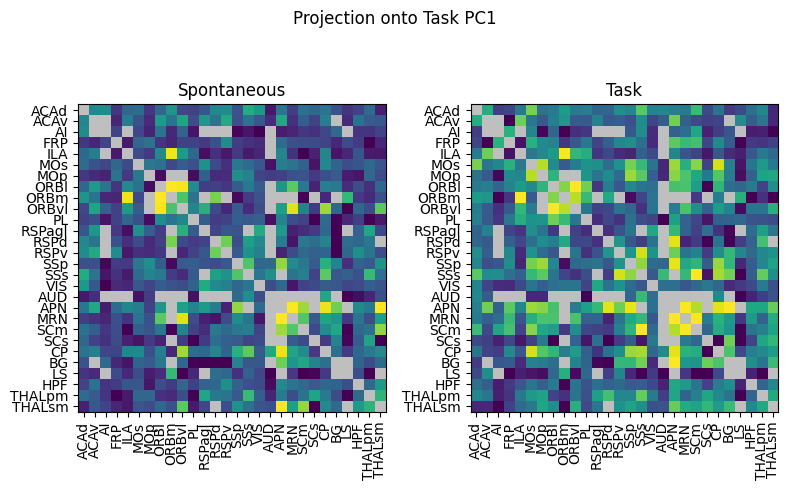

In [138]:
sel_projection_types=['spont_projection_on_task_PC1','task_projection_on_task_PC1_corrected']
proj_type_names=['Spontaneous', 'Task']
proj_axis='Projection onto Task PC1'

fig,ax=plt.subplots(1,2,figsize=(8,5))

for ii, sel_projection_type in enumerate(sel_projection_types):
    masked_array = np.ma.array(corr_matrix_dict[sel_projection_type], mask=np.isnan(corr_matrix_dict[sel_projection_type]))
    cmap = matplotlib.cm.viridis
    cmap.set_bad('grey',0.5)

    im=ax[ii].imshow(np.abs(masked_array), aspect='equal', cmap=cmap, vmin=0.1, vmax=0.6, extent=[-0.5,len(incl_structures)-0.5,len(incl_structures)-0.5,-0.5])
    ax[ii].set_xticks(np.arange(len(incl_structures)), incl_structures, rotation=90)
    ax[ii].set_yticks(np.arange(len(incl_structures)), incl_structures)
    ax[ii].set_title(proj_type_names[ii])
    # #colorbar
    # if ii==len(sel_projection_types)-1:
    #     cbar = plt.colorbar(im, ax=ax[ii])
    #     cbar.set_label('mean Pearson r between\ncontext dimension projections')

fig.suptitle(proj_axis)

fig.tight_layout()

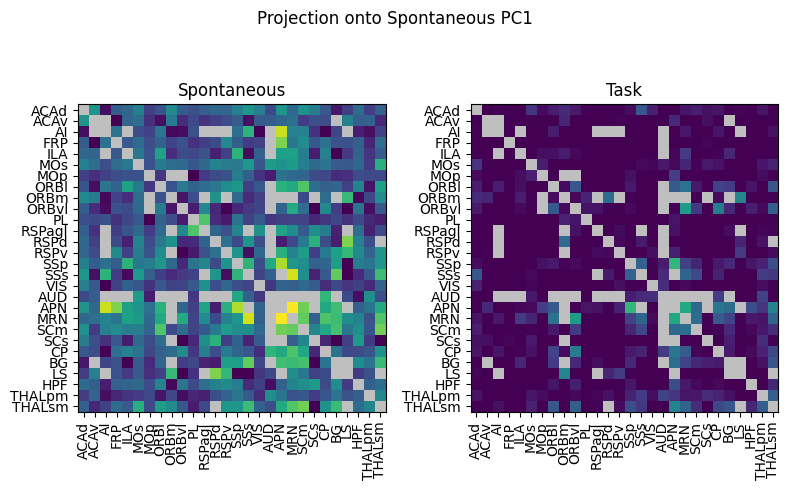

In [139]:
sel_projection_types=['spont_projection_on_spont_PC1','task_projection_on_spont_PC1_corrected']
proj_type_names=['Spontaneous', 'Task']
proj_axis='Projection onto Spontaneous PC1'

fig,ax=plt.subplots(1,2,figsize=(8,5))

for ii, sel_projection_type in enumerate(sel_projection_types):
    masked_array = np.ma.array(corr_matrix_dict[sel_projection_type], mask=np.isnan(corr_matrix_dict[sel_projection_type]))
    cmap = matplotlib.cm.viridis
    cmap.set_bad('grey',0.5)

    im=ax[ii].imshow(np.abs(masked_array), aspect='equal', cmap=cmap, vmin=0.1, vmax=0.6, extent=[-0.5,len(incl_structures)-0.5,len(incl_structures)-0.5,-0.5])
    ax[ii].set_xticks(np.arange(len(incl_structures)), incl_structures, rotation=90)
    ax[ii].set_yticks(np.arange(len(incl_structures)), incl_structures)
    ax[ii].set_title(proj_type_names[ii])
    # #colorbar
    # if ii==len(sel_projection_types)-1:
    #     cbar = plt.colorbar(im, ax=ax[ii])
    #     cbar.set_label('mean Pearson r between\ncontext dimension projections')

fig.suptitle(proj_axis)

fig.tight_layout()

In [111]:
from scipy.cluster.hierarchy import dendrogram
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

    return linkage_matrix

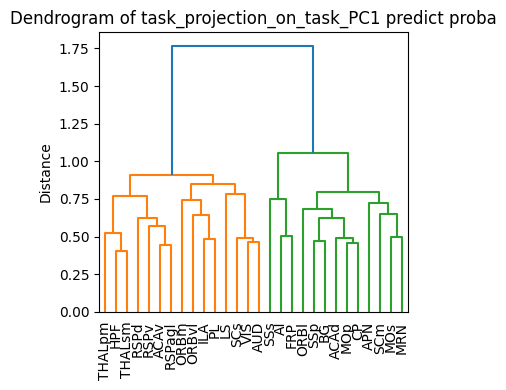

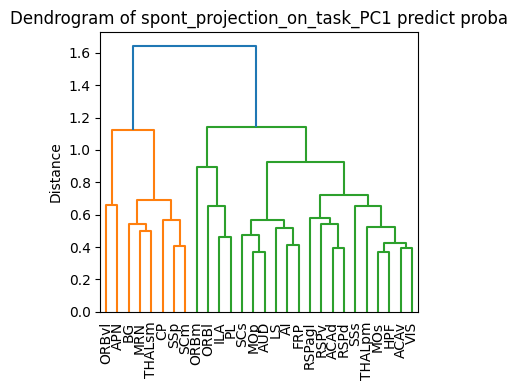

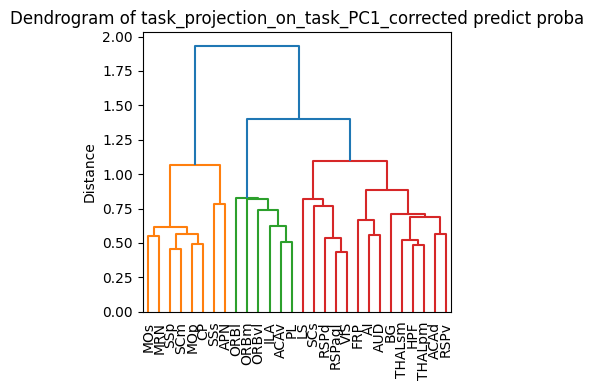

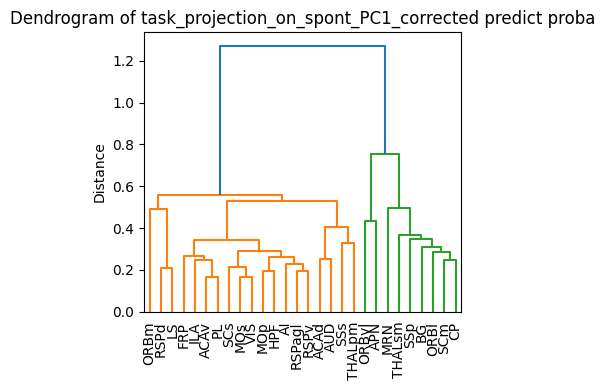

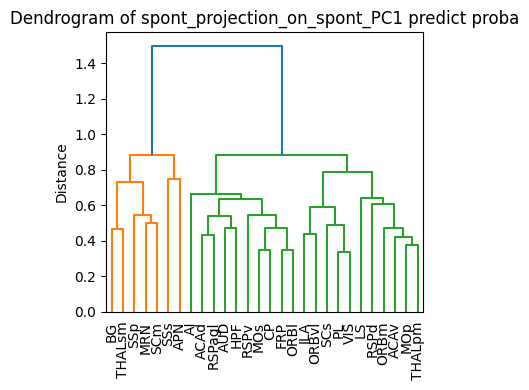

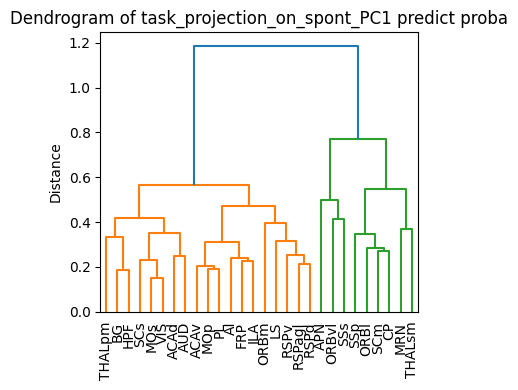

In [140]:
from sklearn.cluster import AgglomerativeClustering

sort_idx={}
use_epochs=list(corr_matrix_dict.keys())

# fig,ax=plt.subplots(1,3,figsize=(11,4),sharey=True)

clustering_dict={}

ax_max=[]

for ee, epoch in enumerate(use_epochs):
    fig,ax=plt.subplots(figsize=(4,4))
    corr_matrix=corr_matrix_dict[epoch].copy()

    #hierarchical clustering
    clustering = AgglomerativeClustering(
        n_clusters=2,
        metric='euclidean',
        linkage='ward',
        compute_distances=True,
    )

    corr_matrix[corr_matrix==1]=np.nan
    naninds=np.isnan(corr_matrix)
    corr_matrix[naninds]=np.nanmedian(corr_matrix[corr_matrix!=1])
    clustering.fit(corr_matrix)

    idx = np.argsort(clustering.labels_)

    sort_idx[epoch] = idx

    linkage_matrix=plot_dendrogram(clustering,labels=incl_structures,ax=ax)#, truncate_mode="level", p=3)
    ax.set_ylabel('Distance')
    ax.set_title(f'Dendrogram of {epoch} predict proba')
    ax.tick_params(axis='x', rotation=90)

    clustering_dict[epoch]=clustering

    # ax_max.append(np.diff(ax[ee].get_ylim()))

    #set ylim to max of any axis
    # ax.set_ylim(0,np.max(ax_max))

    fig.tight_layout()

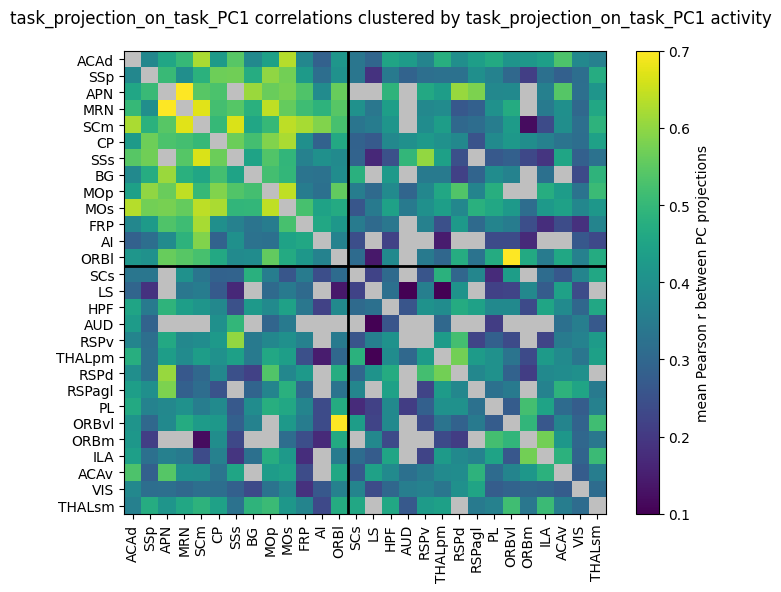

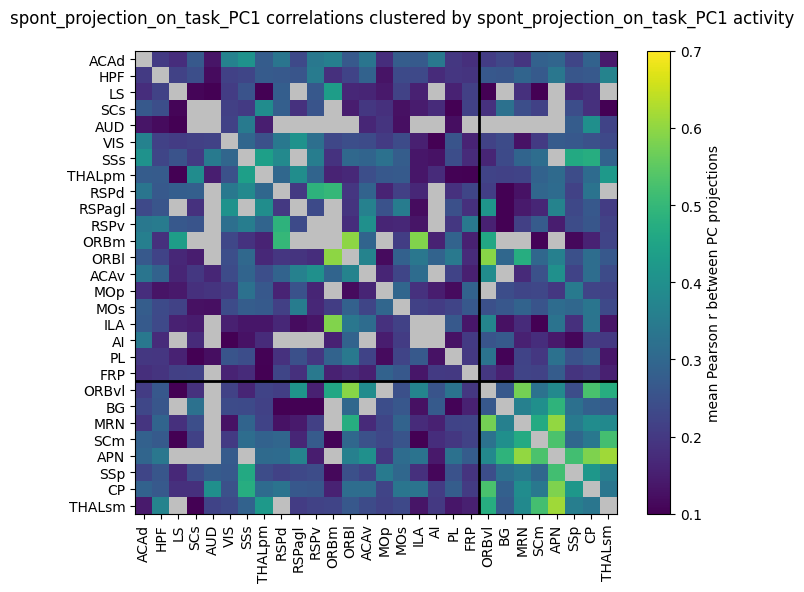

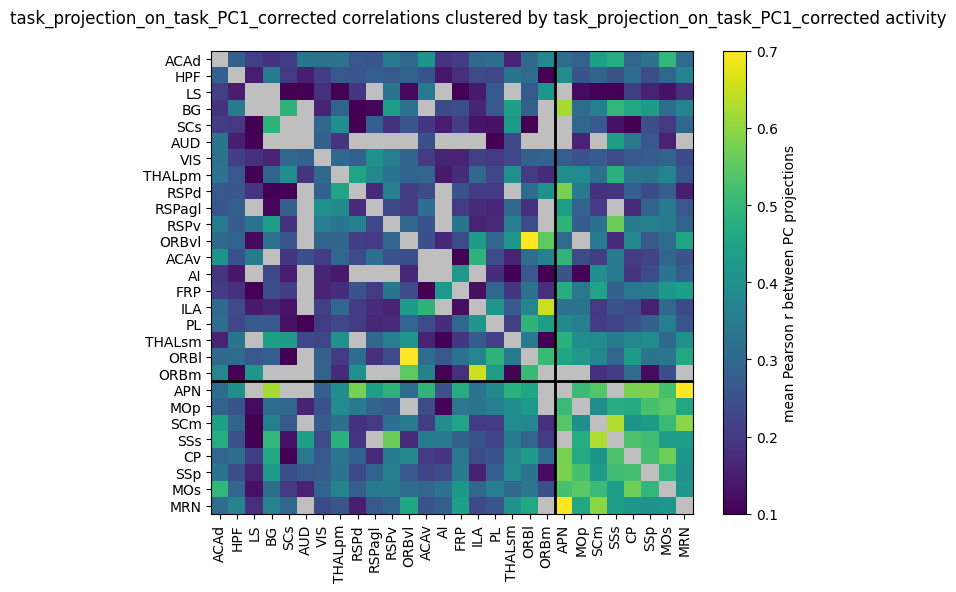

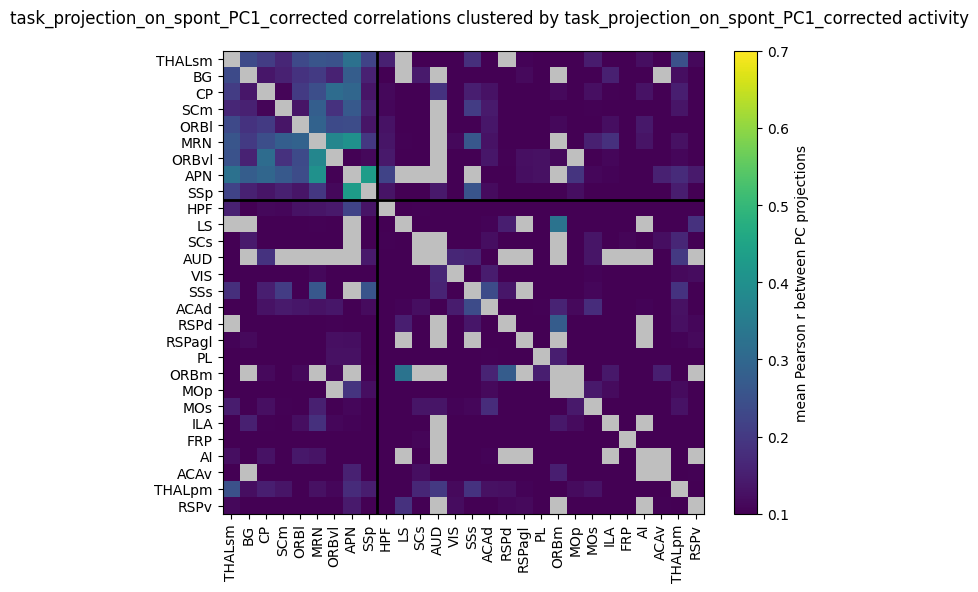

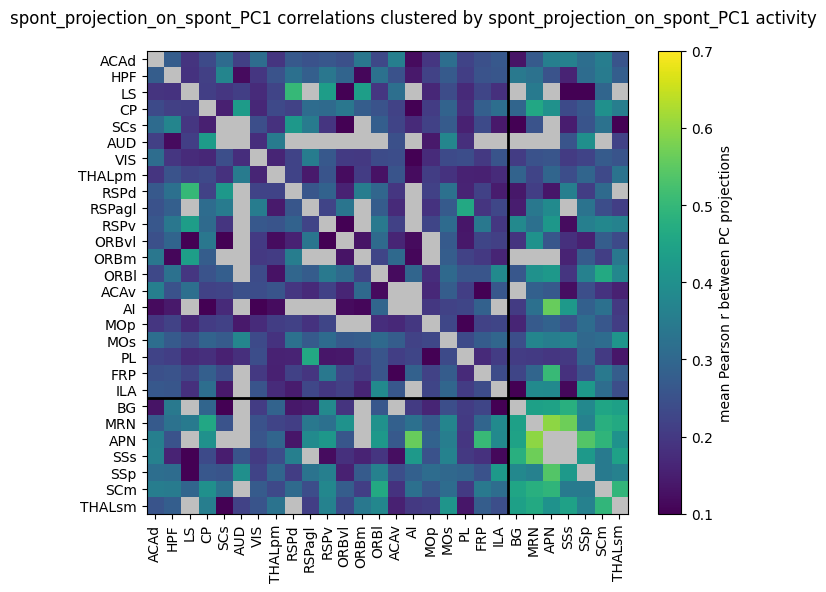

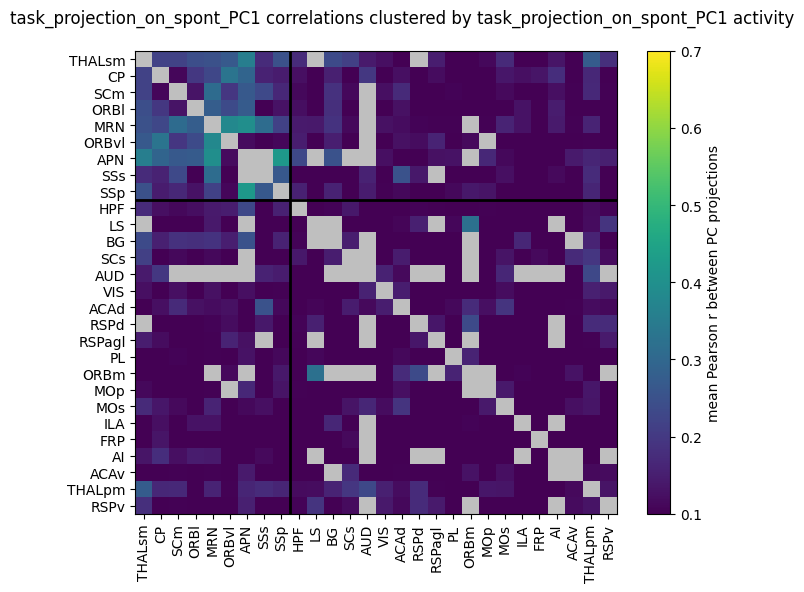

In [141]:

sortby=None #'task','spont','task-spont', or None

for ee, epoch in enumerate(use_epochs):

    corr_matrix=corr_matrix_dict[epoch].copy()
    cmap = matplotlib.cm.viridis
    vmin=0.1
    vmax=0.7

    if sortby is not None:
        sel_sort_idx=sort_idx[sortby]
        sort_str=sortby
    else:
        sel_sort_idx=sort_idx[epoch]
        sort_str=epoch

    masked_array = np.ma.array(corr_matrix, mask=np.isnan(corr_matrix))
    cmap.set_bad('grey',0.5)

    fig,ax=plt.subplots(1,1,figsize=(7,6))
    im=ax.imshow(np.abs(masked_array[sel_sort_idx][:,sel_sort_idx]), aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax, extent=[-0.5,len(incl_structures)-0.5,len(incl_structures)-0.5,-0.5])
    ax.set_xticks(np.arange(len(incl_structures)), np.array(incl_structures)[sel_sort_idx], rotation=90)
    ax.set_yticks(np.arange(len(incl_structures)), np.array(incl_structures)[sel_sort_idx])

    cluster_borders = np.where(np.diff(np.sort(clustering_dict[epoch].labels_)) != 0)[0] + 0.5

    for xx in cluster_borders:
        ax.axvline(x=xx, color='black', linestyle='-', linewidth=2)
        ax.axhline(y=xx, color='black', linestyle='-', linewidth=2)

    #colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('mean Pearson r between PC projections')
    fig.suptitle(f'{epoch} correlations clustered by {sort_str} activity')
    fig.tight_layout()


In [142]:
# corr_matrix
